In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.0 MB/s eta 0:00:00


### General note for GPU training (in colab)

* First, please use the GPU runtime. If so the `!nvidia-smi` will return no error.
  1. Click on "Runtime" in the top menu bar.
  2. Select "Change runtime type" from the drop-down menu.
  3. In the "Runtime type" section, select "GPU" as the hardware accelerator.
  4. Click "Save" to apply the changes.


* What should I do with **Cuda out of memory error.**? (this is THE most common error in DL)
![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*enMsxkgJ1eb9XvtWju5V8Q.png)
  1. In colab notebook, **unfortunately, you need to restart the kernel after OOM happened**. Or it will keep happening no matter what.
  2. Change the model to save memory, usually includes, decrease batch size, decrease the number of layers, decrease the max sequence length, decrease the hidden / embedding dimension
  3. If you know mixed precision training, you can switch to low precision `fp16` numbers for weights and inputs.

* What should I do for the **Device siee assert triggered** error
  > RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
  
  * Usually it's because the embedding layer receive an index (token id or position id) not stored in it.
  * Could be sth. else, which will be harder to debug...

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" # to fix a potential locale bug
!nvidia-smi

Wed Apr 19 19:48:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    34W /  70W |   8617MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Imports

In [ ]:
## Import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertModel, BertConfig
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2Model
## import MNIST from torchvision package
from torchvision import datasets, transforms
## import torch
import os
from os.path import join
from tqdm.notebook import tqdm, trange
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
#%%
from torchvision.datasets import MNIST

dataset = MNIST(root='/content/', download=True, transform=transforms.ToTensor())


### Utils for Image as Sequence

In [ ]:
# image to patch sequence by convolution
def img2patch(img, patch_size=2):
    # img: (batch_size, channel, height, width)
    # patch_size: int
    # return: (batch_size, channel, height//patch_size, width//patch_size, patch_size**2)
    batch_size, channel, height, width = img.shape
    img = img.reshape(batch_size, channel, height//patch_size, patch_size, width//patch_size, patch_size)
    img = img.permute(0, 2, 4, 1, 3, 5)
    img = img.reshape(batch_size, height//patch_size, width//patch_size, channel * patch_size**2)
    return img


def patch2seq(patches):
    batch_size, height, width, channel = patches.shape
    return patches.reshape(batch_size, height*width, channel)


def seq2img(patch_seq, patch_size=2):
    # patch_seq: (batch_size, channel, height//patch_size, width//patch_size, patch_size**2)
    # patch_size: int
    # return: (batch_size, channel, height, width)
    batch_size, HW, hidden = patch_seq.shape
    height = width = int(math.sqrt(HW))
    channel = hidden // patch_size**2
    patch_seq = patch_seq.reshape(batch_size, height, width, channel, patch_size, patch_size)
    patch_seq = patch_seq.permute(0, 3, 1, 4, 2, 5)
    imgtsr = patch_seq.reshape(batch_size, channel, height*patch_size, width*patch_size)
    return imgtsr


dataloaders = DataLoader(dataset, batch_size=64, shuffle=True)
imgs, labels = next(iter(dataloaders))
print(patch2seq(img2patch(imgs, patch_size=4)).shape)
assert torch.allclose(seq2img(patch2seq(img2patch(imgs,)),), imgs)
assert torch.allclose(seq2img(patch2seq(img2patch(imgs, patch_size=4)), patch_size=4), imgs)

torch.Size([64, 49, 16])


### Conditional Generation by Cross attention

In [ ]:
#%% Conditional model
patch_size = 4
config = GPT2Config(n_embd=128, n_layer=24, n_head=16, n_positions=256,
                    vocab_size=100, bos_token_id=101, eos_token_id=102,
                    add_cross_attention=True, )

model = GPT2Model(config).cuda()
patch_emb = nn.Linear(patch_size * patch_size, config.n_embd).cuda()
patch_readout = nn.Linear(config.n_embd, patch_size * patch_size).cuda()
digit_emb = nn.Embedding(10, config.n_embd).cuda()
optimizer = AdamW([*model.parameters(),
                     *patch_emb.parameters(),
                        *patch_readout.parameters(),
                   *digit_emb.parameters()], lr=5e-4)

In [ ]:
def generate_img(prompt_digit, prompt_patch, model, digit_emb, patch_emb, patch_readout,
                 patch_size=4, pixel_size=28):
    max_seq_len = (pixel_size // patch_size) ** 2 - 1
    prompt_digit_emb = digit_emb(torch.tensor([*prompt_digit]).cuda())[:, None, :]
    patch_seq = [prompt_patch]
    input_patch_emb = patch_emb(prompt_patch)
    with torch.no_grad():
        for i in range(max_seq_len):
            output = model(inputs_embeds=input_patch_emb,
                           encoder_hidden_states=prompt_digit_emb)
            output_hiddens = output.last_hidden_state
            next_patch = patch_readout(output_hiddens[:, -1:, :])
            input_patch_emb = torch.cat([input_patch_emb, patch_emb(next_patch)], dim=1)
            patch_seq.append(next_patch)

    patch_seq_tsr = torch.cat(patch_seq, dim=1)
    gen_imgs = seq2img(patch_seq_tsr, patch_size=patch_size)
    return gen_imgs

In [ ]:
saveroot = r"/content/patchGPT"
runname = "conditional"
os.makedirs(join(saveroot, runname), exist_ok=True)
batch_size = 392 # 256 # 512 # 1024
dataloaders = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in trange(1,50):
    pbar = tqdm(dataloaders)
    model.train()
    for ibatch, (imgs, labels) in enumerate(pbar):
        digit_hiddens = digit_emb(labels.cuda())[:, None, :]
        patch_seq = patch2seq(img2patch(imgs.cuda(), patch_size=patch_size))
        input_embeds = patch_emb(patch_seq)
        output = model(inputs_embeds=input_embeds, encoder_hidden_states=digit_hiddens)
        output_hiddens = output.last_hidden_state
        output_patches = patch_readout(output_hiddens)
        loss = F.mse_loss(output_patches[:, :-1, :], patch_seq[:, 1:, :])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")
        # print(loss.item())

    prompt_digit = range(10)
    prompt_patch = torch.zeros(10, 1, patch_size * patch_size).cuda()
    model.eval()
    gen_imgs = generate_img(prompt_digit, prompt_patch, model, digit_emb, patch_emb, patch_readout,
                            patch_size=patch_size, pixel_size=28)
    save_image(make_grid(gen_imgs, nrow=5), join(saveroot, runname, f'{epoch}_genimages.png'))

model.save_pretrained(join(saveroot, runname, "model"))
patch_emb.cpu().save(join(saveroot, runname, "patch_emb.pth"))
patch_readout.cpu().save(join(saveroot, runname, "patch_readout.pth"))

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Samples after 2 epoches of training

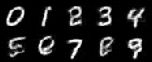

Samples after 15 epoches

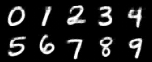

In [ ]:
torch.save(model.state_dict(),"pathGPT_cond.pth")
!du -sh pathGPT_cond.pth

28M	pathGPT_cond.pth


In [ ]:
prompt_digit = range(10)
prompt_patch = torch.zeros(10, 1, patch_size * patch_size).cuda()
gen_imgs = generate_img(prompt_digit, prompt_patch, model, digit_emb, patch_emb, patch_readout,
                        patch_size=patch_size, pixel_size=28)
plt.figure()
plt.imshow(make_grid(gen_imgs, nrow=5).permute(1, 2, 0).cpu())
plt.show()

### Unconditional Generation

In [ ]:
def generate_img_uncond(prompt_patch, model, patch_emb, patch_readout,
                 patch_size=4, pixel_size=28):
    max_seq_len = (pixel_size // patch_size) ** 2 - 1
    patch_seq = [prompt_patch]
    input_patch_emb = patch_emb(prompt_patch)
    with torch.no_grad():
        for i in range(max_seq_len):
            output = model(inputs_embeds=input_patch_emb,)
            output_hiddens = output.last_hidden_state
            next_patch = patch_readout(output_hiddens[:, -1:, :])
            input_patch_emb = torch.cat([input_patch_emb, patch_emb(next_patch)], dim=1)
            patch_seq.append(next_patch)

    patch_seq_tsr = torch.cat(patch_seq, dim=1)
    gen_imgs = seq2img(patch_seq_tsr, patch_size=patch_size)
    return gen_imgs


In [ ]:
patch_size = 4
config = GPT2Config(n_embd=128, n_layer=24, n_head=16, n_positions=256,
                    vocab_size=100, bos_token_id=101, eos_token_id=102, )
model = GPT2Model(config).cuda()
patch_emb = nn.Linear(patch_size * patch_size, config.n_embd).cuda()
patch_readout = nn.Linear(config.n_embd, patch_size * patch_size).cuda()
optimizer = AdamW([*model.parameters(),
                   *patch_emb.parameters(),
                   *patch_readout.parameters()], lr=5e-4)
saveroot = r"/content/patchGPT"
runname = "unconditional"
os.makedirs(join(saveroot, runname), exist_ok=True)

In [ ]:
batch_size = 392 # 512
dataloaders = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in range(50):
    pbar = tqdm(dataloaders)
    model.train()
    for ibatch, (imgs, labels) in enumerate(pbar):
        patch_seq = patch2seq(img2patch(imgs.cuda(), patch_size=patch_size))
        input_embeds = patch_emb(patch_seq)
        output = model(inputs_embeds=input_embeds)
        output_hiddens = output.last_hidden_state
        output_patches = patch_readout(output_hiddens)
        loss = F.mse_loss(output_patches[:, :-1, :], patch_seq[:, 1:, :])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")
        # print(loss.item())

    prompt_digit = range(10)
    prompt_patch = torch.zeros(10, 1, patch_size * patch_size).cuda()
    model.eval()
    gen_imgs = generate_img_uncond(prompt_patch, model, patch_emb, patch_readout,
                            patch_size=patch_size, pixel_size=28)
    save_image(make_grid(gen_imgs, nrow=5), join(saveroot, runname, f'{epoch}_genimages.png'))

model.save_pretrained(join(saveroot, runname, "model"))
patch_emb.cpu().save(join(saveroot, runname, "patch_emb.pth"))
patch_readout.cpu().save(join(saveroot, runname, "patch_readout.pth"))


In [ ]:
make_grid(seq2img(output_patches, patch_size=patch_size))
# plt.imshow(make_grid(imgs[:16, :, :, :]).permute(1, 2, 0))
plt.figure()
plt.imshow(make_grid(seq2img(output_patches.detach().cpu(), patch_size=patch_size)).permute(1, 2, 0))
plt.show()